## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil, itertools, sys, random
from IPython.display import clear_output

In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.0
gnn_opts.initial_dev = 1.0
gnn_opts.dropout_rate = 0.1

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 200
learn_opts.lr = 0.0001
learn_opts.batch_size = 128

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
#!Important: For production, random train and test may be preferred
myopts.random_stratify = True
myopts.cache_dir = '/tmp/moldata'
#Important! If you repeat experiments within the same dataset version, set to False
myopts.clear_cache = False
myopts.train_keys = 'keys/keys_klifs'
myopts.kinase_list = 'keys/kinase_list'
#Important!: The newest version is 3, still 1 and 2 are acceptible, 4 for silly atom feature disabling setup
myopts.dataset_version = 4
myopts.cpu_count = 10

In [7]:
__ver = myopts.dataset_version
assert __ver in list(range(1, 5))
if __ver == 1:
    import dataset as ds
elif __ver == 2:
    import dataset2 as ds
elif __ver ==  3:
    import dataset3 as ds
else:
    print('This is a silly setup, practically disabling atom features', file=sys.stderr)
    import dataset4 as ds

This is a silly setup, practically disabling atom features


### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))
        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(test_pred, 0)
    test_true = np.concatenate(test_true, 0)
    test_pred = np.array(test_pred)
    test_true = np.array(test_true)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [33]:
import pickle
ns = []
for f in glob.glob('data/*'):
    data = pickle.load(open(f, 'rb'))
    ligand_mol = data[0]
    pocket_mol = data[1]
    print(f, val, pocket_mol.GetNumAtoms())
    ns.append(pocket_mol.GetNumAtoms())

data/lck_C66133187 0 51
data/kit_C04223612 0 52
data/egfr_C01637582 0 63
data/met_C62721010 0 47
data/hdac2_C50113529 0 83
data/cah2_C37193713 0 53
data/vgfr2_C39584670 0 87
data/casp3_C34922839 0 33
data/ppard_C66961641 0 64
data/bace1_C39597442 0 67
data/fgfr1_C15300925 0 80
data/drd3_C41584726 0 39
data/pgh1_C05809351 0 48
data/bace1_C13367477 0 66
data/tryb1_C15947126 0 44
data/dpp4_C35339983 0 51
data/fkb1a_C40233097 0 46
data/tgfr1_C04817811 0 67
data/mk14_C16650996 0 116
data/fa10_C01897357 0 75
data/lck_C40768668 0 20
data/parp1_C28826235 0 75
data/fpps_C13422385 0 93
data/mmp13_C08934633 0 37
data/ada17_C02639694 0 81
data/egfr_C35590782 0 68
data/kith_C67389145 0 67
data/src_C13031909 0 75
data/cdk2_C35633366 0 47
data/cdk2_C05735911 0 49
data/fnta_C30492629 0 44
data/ptn1_C36053045 0 45
data/hmdh_C35925186 0 19
data/braf_C38975113 0 84
data/ital_C08771157 0 29
data/cah2_C13052074 0 81
data/cah2_C16341771 0 25
data/thrb_C12340633 0 46
data/gcr_C14273704 0 47
data/dpp4_C635867

data/try1_C03007261 0 49
data/dpp4_C56075417 0 64
data/pnph_C40472636 0 69
data/dpp4_C49752264 0 35
data/gria2_C15866151 0 32
data/kpcb_C64220530 0 58
data/nram_C19724122 0 24
data/egfr_C66926734 0 66
data/esr1_C05901954 0 38
data/thrb_C56481562 0 77
data/ada17_C35852451 0 55
data/esr2_C63885762 0 74
data/urok_C19502594 0 62
data/bace1_C39561152 0 52
data/pparg_C55638072 0 88
data/bace1_C18900366 0 42
data/lck_C59310122 0 27
data/bace1_C20832793 0 56
data/dhi1_C06806717 0 101
data/pparg_C32972829 0 78
data/egfr_C62893326 0 38
data/thrb_C09579659 0 56
data/prgr_C17729674 0 126
data/fpps_C19720228 0 60
data/lck_C63679653 0 21
data/bace1_C39302467 0 68
data/hdac2_C48310487 0 23
data/hivpr_C59233791 0 26
data/lck_C50031930 0 66
data/gria2_CHEMBL421990 0 30
data/ppard_C13055730 0 114
data/fnta_C03142399 0 14
data/tgfr1_C38726187 0 83
data/src_C24986391 0 60
data/vgfr2_C45026101 0 26
data/glcm_C52036215 0 39
data/cdk2_C62843840 0 27
data/bace1_C22809438 0 52
data/ada17_C39747790 0 72
data/dh

In [40]:
max(ns)

176

(array([  0.,  17.,  62., 117., 147., 160., 165., 108.,  81.,  61.,  34.,
         13.,  10.,   8.,   1.,   0.,   0.,   0.,   1.,   0.]),
 array([  0,   5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115,
        125, 135, 145, 155, 165, 175, 185, 195]),
 <a list of 20 Patch objects>)

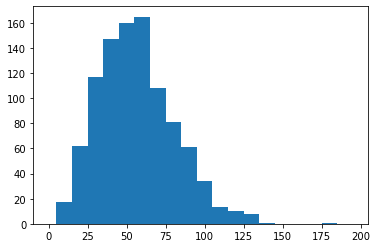

In [38]:
plt.hist(ns, bins=[0,5,15,25,35,45,55,65,75,85,95,105,115,125,135,145,155,165,175,185,195])

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify, kinase_check=False)

T = []
for key, pkd in train_keys:
    if 8.5 <= pkd:
        T.append((key, 1))
    elif pkd < 5.5:
        T.append((key, 0))
train_keys = T

T = []
for key, pkd in test_keys:
    if 8.5 <= pkd:
        T.append((key, 1))
    elif pkd < 5.5:
        T.append((key, 0))
test_keys = T

if False: # for testing with CPU
    train_keys = train_keys[:90]
    test_keys = test_keys[:30]

# print(train_keys)
write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(224, 72, 374)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in test_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(224, 72)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2
gnn_opts.N_atom_features

1

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

Epoch: 35	Lapse: 5.3s	Losses: (0.212, 0.207)	Best: (0.212, 0.207)


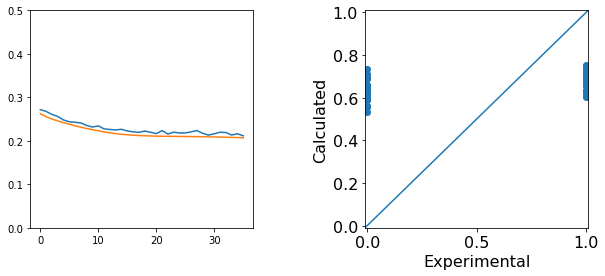

rmse: 0.455, mae: 0.428, r2: 0.556, rho: 0.541


KeyboardInterrupt: 

In [15]:
CLEAR_OUTPUT_WHEN_UPDATE = True
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    output = output or epoch == learn_opts.num_epochs - 1

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        L = list(itertools.chain.from_iterable(L))
        write_results_to_csv(L, X, y, np.abs(X-y), epoch)
        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))

    if output:
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))